# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [613]:
import requests
import bs4
from bs4 import BeautifulSoup
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, recall_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

In [3]:
## YOUR CODE HERE
r = requests.get("http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

In [4]:
r.content

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta http-equiv="content-type" content="text/html;charset=UTF-8">\n<!-- pll --><script type="text/javascript" src="/s/4a89ac5/en_US.js"></script>\n<link href="/s/a6a334e/jobsearch_all.css" rel="stylesheet" type="text/css">\n<link rel="alternate" type="application/rss+xml" title="Data Scientist $20,000 Jobs, Employment in New York State" href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&l=New+York">\n<link rel="alternate" media="handheld" href="/m/jobs?q=data+scientist+%2420%2C000&l=New+York">\n<script type="text/javascript">\n    \n    window[\'closureReadyCallbacks\'] = [];\n\n    function call_when_jsall_loaded(cb) {\n        if (window[\'closureReady\']) {\n            cb();\n        } else {\n            window[\'closureReadyCallbacks\'].push(cb);\n        }\n    }\n</script>\n\n<script type="text/javascript" src="/s/40c36c1/jobsearch-all-compiled.js"></script>\n            <script type="text/javascript">\nvar pingUrlsForGA = 

In [5]:
ind_soup = BeautifulSoup(r.content, "lxml")

In [6]:
for item in ind_soup.findAll("div", class_=" row result"):
    print item.prettify()
    print ""
    print ""

<div class=" row result" data-jk="573189c2f3d45325" data-tn-component="organicJob" id="p_573189c2f3d45325" itemscope="" itemtype="http://schema.org/JobPosting">
 <h2 class="jobtitle" id="jl_573189c2f3d45325">
  <a class="turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=573189c2f3d45325&amp;fccid=b48c1ad7c88be1fe" itemprop="title" onclick="setRefineByCookie(['salest']); return rclk(this,jobmap[0],true,0);" onmousedown="return rclk(this,jobmap[0],0);" rel="nofollow" target="_blank" title="Data Scientist">
   <b>
    Data
   </b>
   <b>
    Scientist
   </b>
  </a>
 </h2>
 <span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
  <span itemprop="name">
   Intent Media
  </span>
 </span>
 -
 <span itemprop="jobLocation" itemscope="" itemtype="http://schema.org/Place">
  <span class="location" itemprop="address" itemscope="" itemtype="http://schema.org/Postaladdress">
   <span itemprop="addressLocality">
    New York, NY
   </span>
  </span>


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [7]:
def title_from_code(result):
    titles = []
    for items in result.findAll("h2", class_="jobtitle"):
        titles.append(items.text)
    return titles

title_from_code(ind_soup)

[u'\nData Scientist\n',
 u'\nData Scientist\n',
 u'\nGrubHub - Data Scientist\n',
 u'\nData Scientist\n',
 u'\nData Scientist\n',
 u'\nData Scientist\n',
 u'\nData Scientist\n',
 u'\nData Scientist\n',
 u'\nBioinformatics Data Scientist - Cancer Genomics, NYC\n',
 u'\nResearch Lead / Data Scientist\n']

In [8]:
## YOUR CODE HERE

def location_from_code(result):
    locations = []
    for items in result.findAll("span", class_="location"):
        locations.append(items.text)
    return locations

location_from_code(ind_soup)

[u'New York, NY',
 u'New York, NY',
 u'Long Beach, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY 10013 (Tribeca area)',
 u'New York, NY',
 u'New York, NY 10007 (Financial District area)',
 u'New York, NY',
 u'New York, NY 10065 (Upper East Side area)',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY',
 u'New York, NY']

In [9]:
def company_from_code(result):
    companies = []
    for items in result.findAll("span", class_ = "company"):
        items = items.text
        newitems = items.replace("\n", "")
        newitems = newitems.replace("    ", "")
        companies.append(newitems)
    return companies

company_from_code(ind_soup)

[u'AbilTo, Inc',
 u'Uber',
 u'Lancer Insurance Company',
 u'Intent Media',
 u'Paperless Post',
 u'Illinois Technology Association',
 u'DISH Network',
 u'ShopKeep',
 u'Tapad',
 u'Verizon',
 u'Crisis Text Line',
 u'Memorial Sloan Kettering Cancer Center',
 u'Spotify',
 u'Chegg',
 u'UncommonGoods']

In [10]:
print ind_soup.prettify()

<!DOCTYPE html>
<html lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <!-- pll -->
  <script src="/s/4a89ac5/en_US.js" type="text/javascript">
  </script>
  <link href="/s/a6a334e/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=New+York" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in New York State" type="application/rss+xml"/>
  <link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   window['closureReadyCallbacks'] = [];

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].push(cb);
        }
    }
  </script>
  <script src="/s/40c36c1/jobsearch-all-compiled.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   var pingUrlsForGA = [];

v

In [11]:
def salary_from_code(result):
    salaries = []
    for i in result.findAll("td", class_= "snip"):
        if i.find("nobr") != None:
            newitems = i.find("nobr").text
            newitems = newitems.replace(" a year", "")
            salaries.append(str(newitems))
        else:
            salaries.append("None")
    return salaries

salary_from_code(ind_soup)

['None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None']

In [12]:
type (ind_soup)

bs4.BeautifulSoup

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [13]:
YOUR_CITY = 'Seattle'

In [223]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 600

results = []
urllist = []

for city in set(['New+York', 'San+Francisco', 'Austin', YOUR_CITY, "Boston", "Raleigh", "Charlotte", "Chicago", "Portland", "New+Orleans", "Denver"]):
    for start in range(0, max_results_per_city, 10):
        newurl = url_template.replace("{}", city, 1)
        newurl = newurl.replace("{}", str(start))
        urllist.append(newurl)

for url in urllist:
    r = requests.get(url)
    inds_soups = BeautifulSoup(r.content, "lxml")
    for item in inds_soups.findAll("div", class_=" row result"):
        results.append(item)

In [224]:
print len(urllist)
print len(results)

720
5186


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [225]:
## YOUR CODE HERE

locations = []
title = []
company = []
salary = []

for item in results:
    locations.append(''.join(location_from_code(item)))
    title.append(''.join(title_from_code(item)))
    company.append(''.join(company_from_code(item)))
    salary.append(''.join(salary_from_code(item)))

In [226]:
print len(title)
print len(locations)
print len(company)
print len(salary)

5186
5186
5186
5186


In [227]:
locations

[u'Palisades, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY 10065 (Upper East Side area)',
 u'Manhattan, NY',
 u'New York, NY',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY 10004 (Financial District area)',
 u'New York, NY 10032 (Washington Heights area)',
 u'Palisades, NY',
 u'New York, NY',
 u'New York, NY 10010 (Gramercy area)',
 u'New York, NY 10012 (Little Italy area)',
 u'New York, NY',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY',
 u'Manhasset, NY',
 u'New York, NY',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY 10011 (Chelsea area)',
 u'New York, NY 10005 (Financial District area)',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY',
 u'New York, 

In [228]:
df = pd.DataFrame(locations, title)

In [229]:
df["salary"] = salary

In [230]:
df["company"] = company

In [231]:
df.head()

,0,salary,company
\nAssociate Research Scientist\n,"Palisades, NY",None,Columbia University
\nDirector of Data Science and Analytics\n,"New York, NY",None,Paperless Post
\nMachine Learning Engineer\n,"New York, NY",None,Bloomberg
"\nSsr Data Scientist (R, Tableau, Python)\n","New York, NY",None,Globant
"\nBioinformatics Data Scientist - Cancer Genomics, NYC\n","New York, NY 10065 (Upper East Side area)",None,Memorial Sloan Kettering Cancer Center


In [232]:
df.reset_index(inplace = True)

In [233]:
df.head()

,index,0,salary,company
0,\nAssociate Research Scientist\n,"Palisades, NY",None,Columbia University
1,\nDirector of Data Science and Analytics\n,"New York, NY",None,Paperless Post
2,\nMachine Learning Engineer\n,"New York, NY",None,Bloomberg
3,"\nSsr Data Scientist (R, Tableau, Python)\n","New York, NY",None,Globant
4,\nBioinformatics Data Scientist - Cancer Genom...,"New York, NY 10065 (Upper East Side area)",None,Memorial Sloan Kettering Cancer Center


In [234]:
df.columns = ["Title", "Location", "Salary", "Company"]
df.head()

,Title,Location,Salary,Company
0,\nAssociate Research Scientist\n,"Palisades, NY",None,Columbia University
1,\nDirector of Data Science and Analytics\n,"New York, NY",None,Paperless Post
2,\nMachine Learning Engineer\n,"New York, NY",None,Bloomberg
3,"\nSsr Data Scientist (R, Tableau, Python)\n","New York, NY",None,Globant
4,\nBioinformatics Data Scientist - Cancer Genom...,"New York, NY 10065 (Upper East Side area)",None,Memorial Sloan Kettering Cancer Center


In [235]:
df["Salary"].value_counts()

None                        4763
$95 a day                     51
$7,083 - $9,166 a month       43
$4,373 - $6,401 a month       28
$6,250 - $10,833 a month       7
$130,000                       6
$200,000                       6
$150,000                       5
$140,000                       5
$5,400 - $6,500 a month        5
$20.65 an hour                 5
$140,000 - $160,000            4
$85,000                        4
$80,000 - $200,000             4
$70 an hour                    3
$100,000 - $120,000            3
$105,000                       3
$100,000 - $150,000            3
$170,000                       3
$120,000                       3
$68,239 - $85,644              3
$150,000 - $200,000            3
$85,211 - $110,522             3
$110,000 - $200,000            3
$160,000                       3
$20 an hour                    3
$115,000 - $150,000            3
$150,000 - $230,000            3
$40 an hour                    2
$30 an hour                    2
          

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [236]:
## YOUR CODE HERE
df.dtypes

Title       object
Location    object
Salary      object
Company     object
dtype: object

In [237]:
df["Salary"].unique()

array(['None', '$41,057 - $61,669', '$115,000 - $150,000',
       '$117,500 - $127,500', '$30 an hour', '$130,000', '$165,000',
       '$100 - $150 an hour', '$135,000', '$45,488', '$200,000', '$50,000',
       '$150,000', '$150,000 - $300,000', '$105,000', '$60,000 - $90,000',
       '$57,969 - $70,142', '$25 an hour', '$68,239 - $85,644', '$45,000',
       '$140,000 - $200,000', '$59,250', '$46.64 - $60.49 an hour',
       '$85,000 - $105,000', '$80,000 - $120,000', '$500 a week',
       '$66,575 - $83,555', '$40 an hour', '$85,211 - $110,522',
       '$59,536 - $88,649', '$40,774 - $42,000', '$150,000 - $250,000',
       '$61,000 - $62,000', '$100,000 - $200,000', '$64,807 - $85,000',
       '$51,165', '$50,000 - $60,000', '$53,051 - $145,991',
       '$75,243 - $94,834', '$130,000 - $160,000', '$60,000 - $75,000',
       '$70,000 - $80,000', '$130,000 - $175,000', '$75,000 - $100,000',
       '$40,000 - $50,000', '$80,000 - $200,000', '$68,239 - $83,000',
       '$150,000 - $200,00

In [242]:

print df.loc[df['Salary'].str.contains("hour")].index.tolist()
print df.loc[df['Salary'].str.contains("month")].index.tolist()
print df.loc[df['Salary'].str.contains("week")].index.tolist()
print df.loc[df['Salary'].str.contains("day")].index.tolist()

[40, 98, 176, 244, 271, 1221, 1354, 1367, 1395, 1573, 1795, 1887, 1954, 1957, 2337, 2480, 2487, 2622, 2629, 3452, 3786, 3793, 3795, 3801, 3816, 3852, 3862, 3863, 3880, 3881, 3891, 3903, 3909, 3914, 3933, 4101, 4135, 4136, 4150, 4442, 4562, 4575, 4584, 4650, 4803, 4816, 4817, 4979, 5025, 5028]
[1800, 2852, 2860, 2868, 2876, 2884, 2892, 2900, 2908, 2916, 2924, 2932, 2940, 2948, 2956, 2964, 2972, 2980, 2988, 2996, 3004, 3012, 3020, 3028, 3036, 3044, 3052, 3060, 3068, 4143, 4144, 4146, 4153, 4155, 4491, 4581, 4614, 4716, 4739, 4818, 4821, 4866, 4874, 4901, 4903, 4904, 4905, 4928, 4930, 4957, 4975, 4977, 4982, 4984, 4986, 4989, 5000, 5030, 5033, 5048, 5075, 5078, 5081, 5088, 5091, 5097, 5105, 5108, 5110, 5115, 5125, 5129, 5131, 5133, 5135, 5137, 5139, 5141, 5143, 5145, 5147, 5149, 5151, 5153, 5155, 5157, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185]
[268, 2615]
[526, 1241, 124

In [251]:
removeindex = []
removeindex.append(df.loc[df['Salary'].str.contains("hour")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("month")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("week")].index.tolist())
removeindex.append(df.loc[df['Salary'].str.contains("day")].index.tolist())

In [258]:
removeindexfinal = [val for sublist in removeindex for val in sublist]

In [260]:
print removeindexfinal

[40, 98, 176, 244, 271, 1221, 1354, 1367, 1395, 1573, 1795, 1887, 1954, 1957, 2337, 2480, 2487, 2622, 2629, 3452, 3786, 3793, 3795, 3801, 3816, 3852, 3862, 3863, 3880, 3881, 3891, 3903, 3909, 3914, 3933, 4101, 4135, 4136, 4150, 4442, 4562, 4575, 4584, 4650, 4803, 4816, 4817, 4979, 5025, 5028, 1800, 2852, 2860, 2868, 2876, 2884, 2892, 2900, 2908, 2916, 2924, 2932, 2940, 2948, 2956, 2964, 2972, 2980, 2988, 2996, 3004, 3012, 3020, 3028, 3036, 3044, 3052, 3060, 3068, 4143, 4144, 4146, 4153, 4155, 4491, 4581, 4614, 4716, 4739, 4818, 4821, 4866, 4874, 4901, 4903, 4904, 4905, 4928, 4930, 4957, 4975, 4977, 4982, 4984, 4986, 4989, 5000, 5030, 5033, 5048, 5075, 5078, 5081, 5088, 5091, 5097, 5105, 5108, 5110, 5115, 5125, 5129, 5131, 5133, 5135, 5137, 5139, 5141, 5143, 5145, 5147, 5149, 5151, 5153, 5155, 5157, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 268, 2615, 526, 1241, 1243, 

In [243]:
df.iloc[4352]

Title                          \nHadoop/ SME Architect\n
Location    Beaverton, OR 97005 (Central Beaverton area)
Salary                                         $95 a day
Company                                    Themesoft Inc
Name: 4352, dtype: object

In [261]:
df.drop(df.index[removeindexfinal], inplace = True)

In [262]:
df["Salary"].unique()

array(['None', '$41,057 - $61,669', '$115,000 - $150,000',
       '$117,500 - $127,500', '$130,000', '$165,000', '$135,000',
       '$45,488', '$200,000', '$50,000', '$150,000', '$150,000 - $300,000',
       '$105,000', '$60,000 - $90,000', '$57,969 - $70,142',
       '$68,239 - $85,644', '$45,000', '$140,000 - $200,000', '$59,250',
       '$85,000 - $105,000', '$80,000 - $120,000', '$66,575 - $83,555',
       '$85,211 - $110,522', '$59,536 - $88,649', '$40,774 - $42,000',
       '$150,000 - $250,000', '$61,000 - $62,000', '$100,000 - $200,000',
       '$64,807 - $85,000', '$51,165', '$50,000 - $60,000',
       '$53,051 - $145,991', '$75,243 - $94,834', '$130,000 - $160,000',
       '$60,000 - $75,000', '$70,000 - $80,000', '$130,000 - $175,000',
       '$75,000 - $100,000', '$40,000 - $50,000', '$80,000 - $200,000',
       '$68,239 - $83,000', '$150,000 - $200,000', '$68,239 - $80,000',
       '$115,000 - $200,000', '$65,000 - $77,000', '$140,000 - $160,000',
       '$110,000 - $200,0

In [263]:
df.head()

,Title,Location,Salary,Company
0,\nAssociate Research Scientist\n,"Palisades, NY",None,Columbia University
1,\nDirector of Data Science and Analytics\n,"New York, NY",None,Paperless Post
2,\nMachine Learning Engineer\n,"New York, NY",None,Bloomberg
3,"\nSsr Data Scientist (R, Tableau, Python)\n","New York, NY",None,Globant
4,\nBioinformatics Data Scientist - Cancer Genom...,"New York, NY 10065 (Upper East Side area)",None,Memorial Sloan Kettering Cancer Center


In [264]:
df["Salary"].value_counts()

None                   4763
$130,000                  6
$200,000                  6
$150,000                  5
$140,000                  5
$140,000 - $160,000       4
$85,000                   4
$80,000 - $200,000        4
$160,000                  3
$115,000 - $150,000       3
$68,239 - $85,644         3
$110,000 - $200,000       3
$120,000                  3
$150,000 - $200,000       3
$150,000 - $230,000       3
$105,000                  3
$85,211 - $110,522        3
$170,000                  3
$100,000 - $150,000       3
$100,000 - $120,000       3
$125,000                  2
$100,000 - $140,000       2
$150,000 - $250,000       2
$165,000                  2
$66,654                   2
$110,000 - $180,000       2
$110,000 - $130,000       2
$70,000 - $80,000         2
$110,000 - $150,000       2
$80,000 - $120,000        2
                       ... 
$90,000 - $140,000        1
$59,536 - $88,649         1
$68,239 - $83,000         1
$51,165                   1
$115,000 - $200,000 

In [267]:
print len(df["Salary"]) - 4763

203


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [268]:
## YOUR CODE HERE

def salaryfloat(item):
    lists1 = []
    if "None" in item:
        return np.nan
    elif "-" in item:
        item = item.replace("$", "")
        item = item.replace(",", "")
        lists1 = item.split(" - ")
        mean = (float(lists1[0]) + float(lists1[1]))/2
        return mean
    elif "$" in item:
        item = item.replace("$", "")
        item = item.replace(",", "")
        newitem = float(item)
        return newitem

In [269]:
df["Salary"] = df["Salary"].apply(salaryfloat)

In [270]:
df["Salary"].unique()

array([      nan,   51363. ,  132500. ,  122500. ,  130000. ,  165000. ,
        135000. ,   45488. ,  200000. ,   50000. ,  150000. ,  225000. ,
        105000. ,   75000. ,   64055.5,   76941.5,   45000. ,  170000. ,
         59250. ,   95000. ,  100000. ,   75065. ,   97866.5,   74092.5,
         41387. ,   61500. ,   74903.5,   51165. ,   55000. ,   99521. ,
         85038.5,  145000. ,   67500. ,  152500. ,   87500. ,  140000. ,
         75619.5,  175000. ,   74119.5,  157500. ,   71000. ,  155000. ,
        125000. ,  212500. ,   85000. ,  120000. ,   50502.5,  138300. ,
        185000. ,   90000. ,  110000. ,  137500. ,  180000. ,  160000. ,
        142500. ,   21294.5,   84649. ,  162500. ,   74550. ,   49012. ,
        127500. ,  240000. ,  107500. ,   63000. ,   50402. ,  115000. ,
         92524.5,  117234.5,   77829.5,   93645. ,   87792. ,   66654. ,
         44250. ,   27000. ,   47500. ,   77500. ,   43500. ,   70000. ,
         64500. ,   32454.5,   93431. ,   54590. , 

In [271]:
df.head()

,Title,Location,Salary,Company
0,\nAssociate Research Scientist\n,"Palisades, NY",NaN,Columbia University
1,\nDirector of Data Science and Analytics\n,"New York, NY",NaN,Paperless Post
2,\nMachine Learning Engineer\n,"New York, NY",NaN,Bloomberg
3,"\nSsr Data Scientist (R, Tableau, Python)\n","New York, NY",NaN,Globant
4,\nBioinformatics Data Scientist - Cancer Genom...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


In [272]:
df["Title"] = df["Title"].apply(lambda x: x.replace("\n", ""))

In [273]:
df.head()

,Title,Location,Salary,Company
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


In [274]:
df["Title"].unique()

array([u'Associate Research Scientist',
       u'Director of Data Science and Analytics',
       u'Machine Learning Engineer', ...,
       u'Senior NodeJS Fullstack Developer at Clarify, Inc',
       u'Accounting Manager (TX)', u'Medical and Clinical Laboratory'], dtype=object)

In [275]:
print df.iloc[2][0].encode("ascii")

Machine Learning Engineer


In [276]:
df["Title"] = df["Title"].apply(lambda x: x.encode("ascii", "ignore"))

In [277]:
df["Location"] = df["Location"].apply(lambda x: x.encode("ascii", "ignore"))

In [278]:
df["Company"] = df["Company"].apply(lambda x: x.encode("ascii", "ignore"))

In [279]:
df.head()

,Title,Location,Salary,Company
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


### Save your results as a CSV

In [280]:
## YOUR CODE HERE
pd.DataFrame(df).to_csv('indeeddf.csv')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [462]:
## YOUR CODE HERE
indcsv = pd.read_csv("indeeddf.csv")

In [463]:
indcsv.head()

,Unnamed: 0,Title,Location,Salary,Company
0,0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University
1,1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post
2,2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg
3,3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant
4,4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


In [464]:
del indcsv["Unnamed: 0"]
indcsv.head()

,Title,Location,Salary,Company
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [465]:
indcsv["Salary"].values

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [466]:
## YOUR CODE HERE
print indcsv["Salary"].median()

117234.5


In [467]:
def highlow(boops):
    if boops == np.nan:
        return np.nan
    elif boops > 117234.5:
        return "High"
    elif boops <= 117234.5:
        return "Low"

highlow(np.nan)
        

In [468]:
indcsv["SalaryBinary"] = indcsv["Salary"].apply(highlow)

In [469]:
indcsv.sort_values("Salary", ascending = False).head(10)

,Title,Location,Salary,Company,SalaryBinary
2084,Chief Data Scientist,"Boston, MA 02116 (South End area)",240000.0,Jobspring Partners,High
146,Quantitative Analyst for Global Quant Fund,"New York, NY",225000.0,Averity,High
556,Practice Leader for Management Consulting in P...,"Charlotte, NC",212500.0,BIG 6 Search International,High
277,Junior Quantitative Analyst / Developer for $5...,"New York, NY",200000.0,Averity,High
2114,Software Engineer - Machine Learning Team,"Boston, MA",200000.0,NJF Search,High
252,Quantitative Analyst (Fundamental Quant Equiti...,"New York, NY 10022 (Midtown area)",200000.0,Datacom Technology Group,High
391,Senior/ Lead Data Scientist for Digital Media ...,"New York, NY",200000.0,Averity,High
1937,Quantitative Researcher - Statistical Machine ...,"Berkeley, CA",200000.0,NJF Search,High
134,Data Scientist,"Armonk, NY",200000.0,Technical Source,High
1169,"Quantitative Researcher, Machine Learning & Ba...","Chicago, IL",200000.0,NJF Search,High


In [470]:
indcsv["SalaryBinary"].value_counts()

Low     102
High    101
Name: SalaryBinary, dtype: int64

In [471]:
len(indcsv["Title"])

4966

#### Thought experiment: What is the baseline accuracy for this model?

#### YOUR CODE HERE
Baseline accuracy would be about 50% estimated Lows

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [527]:
## YOUR CODE HERE
indcsvrun = pd.concat([indcsv, pd.get_dummies(indcsv["SalaryBinary"])], axis = 1)

In [528]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High,Low
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University,None,0.0,0.0
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post,None,0.0,0.0
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg,None,0.0,0.0
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant,None,0.0,0.0
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center,None,0.0,0.0


In [529]:
del indcsvrun["Low"]
y = indcsvrun["High"]

In [530]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High
0,Associate Research Scientist,"Palisades, NY",NaN,Columbia University,None,0.0
1,Director of Data Science and Analytics,"New York, NY",NaN,Paperless Post,None,0.0
2,Machine Learning Engineer,"New York, NY",NaN,Bloomberg,None,0.0
3,"Ssr Data Scientist (R, Tableau, Python)","New York, NY",NaN,Globant,None,0.0
4,Bioinformatics Data Scientist - Cancer Genomic...,"New York, NY 10065 (Upper East Side area)",NaN,Memorial Sloan Kettering Cancer Center,None,0.0


In [531]:
indcsvrun.dropna(subset = ["Salary"], inplace = True)

In [532]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High
33,"STATISTICIAN, LEVEL I","New York, NY",51363.0,POLICE DEPARTMENT,Low,0.0
36,Machine Learning Data Scientist,"New York, NY",132500.0,All-In Analytics,High,1.0
39,AVP/Quantitative Analyst,"New York, NY 10105 (Midtown area)",122500.0,AllianceBernstein,High,1.0
61,Sr. Machine Learning Data Scientist,"New York, NY",130000.0,Wade & Wendy,High,1.0
85,Lead/Principal Data Scientist,"New York, NY",165000.0,Empiric Solutions,High,1.0


In [533]:
indcsvrun["Location"].unique()

array(['New York, NY', 'New York, NY 10105 (Midtown area)',
       'New York, NY 10032 (Washington Heights area)', 'Armonk, NY',
       'Jefferson Valley-Yorktown, NY',
       'New York, NY 10017 (Midtown area)', 'Manhattan, NY',
       'New York, NY 10018 (Clinton area)',
       'New York, NY 10167 (Midtown area)',
       'New York, NY 10022 (Midtown area)', 'Queens, NY', 'Albany, NY',
       'Brooklyn, NY', 'Charlotte, NC 28202 (Downtown Charlotte area)',
       'Charlotte, NC', 'Chicago, IL', 'Chicago, IL 60603 (Loop area)',
       'Deerfield, IL', 'Des Plaines, IL', 'Hines, IL', 'Bloomingdale, IL',
       'Northbrook, IL 60062', 'San Francisco, CA',
       'San Francisco, CA 94104 (Financial District area)',
       'San Francisco Bay Area, CA', 'Berkeley, CA', 'Oakland, CA',
       'Brisbane, CA', 'San Mateo, CA 94402 (Beresford area)',
       'San Francisco, CA 94108 (Financial District area)',
       'San Mateo, CA', 'Boston, MA', 'Boston, MA 02116 (South End area)',
       'Camb

In [534]:
def citieschange(boops):
    if "CA" in boops:
        return "San Francisco"
    elif "WA" in boops:
        return "Seattle"
    elif "IL" in boops:
        return "Chicago"
    elif "NY" in boops:
        return "New York"
    elif "TX" in boops:
        return "Austin"
    elif "MA" in boops:
        return "Boston"
    elif "OR" in boops:
        return "Portland"
    elif "CO" in boops:
        return "Denver"
    elif "Raleigh" in boops:
        return "Raleigh"
    elif "Triangle" in boops:
        return "Raleigh"
    elif "Wake" in boops:
        return "Raleigh"
    elif "Chapel" in boops:
        return "Raleigh"
    elif "Durham" in boops:
        return "Raleigh"
    elif "Charlotte" in boops:
        return "Charlotte"
    else:
        return boops

indcsvrun["Location"] = indcsvrun["Location"].apply(citieschange)

In [535]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0


In [536]:
indcsvrun["Location"].unique()

array(['New York', 'Charlotte', 'Chicago', 'San Francisco', 'Boston',
       'Denver', 'Austin', 'Raleigh', 'Portland', 'Seattle'], dtype=object)

In [537]:
indcsvrun = pd.concat([indcsvrun, pd.get_dummies(indcsvrun["Location"])], axis = 1)

In [538]:
indcsvrun.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [539]:
indcsvrun["High"].value_counts()

0.0    102
1.0    101
Name: High, dtype: int64

In [540]:
X2 = indcsvrun.drop(["Title", "Location", "Salary", "Company", "SalaryBinary", "High", "Austin"], 1)

In [541]:
X2.head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [542]:
X2.shape

(203, 9)

In [543]:
y2 = indcsvrun["High"]

In [544]:
y2.shape

(203,)

* I MISREAD THE INSTRUCTIONS AND DID EVERYTHING IN SCIKITLEARN. 

In [545]:
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X2, y2)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [546]:
gs.best_params_

{'C': 0.75, 'penalty': 'l1'}

In [547]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

In [548]:
lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,24,9
1.0,12,22


In [549]:
sum(lr_ypred)

31.0

In [550]:
print(classification_report(y_test, lr_ypred, labels=lr.classes_))


             precision    recall  f1-score   support

        0.0       0.67      0.73      0.70        33
        1.0       0.71      0.65      0.68        34

avg / total       0.69      0.69      0.69        67



In [552]:
cross_val_score(lr, X2, y2, cv=5).mean()

0.54219512195121955

In [553]:
lr_model.coef_

array([[ 0.        ,  0.        ,  0.54026026, -0.87955679,  0.        ,
         0.        ,  0.        ,  0.49881151,  0.34421864]])

no suppression gives a better F1 score marginally but gives a lower cross validation score

In [554]:
lr2 = LogisticRegression() 
lr2_model = lr2.fit(X_train, y_train)
lr2_ypred = lr2_model.predict(X_test)
lr2_cm = confusion_matrix(y_test, lr2_ypred, labels=lr2.classes_)
lr2_cm = pd.DataFrame(lr2_cm, columns=lr2.classes_, index=lr2.classes_)
lr2_cm

,0.0,1.0
0.0,24,9
1.0,10,24


In [555]:
print(classification_report(y_test, lr2_ypred, labels=lr2.classes_))

             precision    recall  f1-score   support

        0.0       0.71      0.73      0.72        33
        1.0       0.73      0.71      0.72        34

avg / total       0.72      0.72      0.72        67



In [556]:
cross_val_score(lr2, X2, y2, cv=5).mean()

0.50719512195121952

Model only has a F1 Score of .69 and cross validated score of .54 - it was not very good at predicting values that had high salaries (where there were 1s over 0s), and only marginally better at predicting low salaries (where it predicted 0s over 1s).

In [557]:
lr_model.coef_

array([[ 0.        ,  0.        ,  0.54026026, -0.87955679,  0.        ,
         0.        ,  0.        ,  0.49881151,  0.34421864]])

Coefficents show that nearly half of the locations were completely suppressed in the end equation. 

*BELOW IS THE RESULT FOR STATSMODEL

In [561]:
X2["Target"] = 1

In [562]:
X2.head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Target
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [563]:
X2s = X2.as_matrix(columns = None)
y2s = y2.as_matrix(columns = None)

In [564]:
mdl = sm.MNLogit(y2s, X2s)
mdl_fit = mdl.fit()

         Current function value: 0.598336
         Iterations: 35


/Users/katty/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [565]:
mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:                        MNLogit   Df Residuals:                      193
Method:                           MLE   Df Model:                            9
Date:                Wed, 06 Jul 2016   Pseudo R-squ.:                  0.1368
Time:                        15:11:36   Log-Likelihood:                -121.46
converged:                      False   LL-Null:                       -140.71
                                        LLR p-value:                 1.424e-05
==============================================================================
       y=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0498      0.767      1.369      0.171        -0.453     2.553
x2            21.7219    1.3e+04      0.002      0.999     -2.55e+04  2.56e+04
x3             1.8458      0.743      2.483      0.013         0.389     3.303
x4            -0.4055      1.000     -0.405      0.685        -2.365     1.554
x5             1.1394      0.699      1.631      0.103        -0.230     2.508
x6           -16.8484   6443.051     -0.003      0.998     -1.26e+04  1.26e+04
x7             0.8267      0.900      0.919      0.358        -0.937     2.590
x8             2.6184      0.775      3.377      0.001         1.099     4.138
x9             2.3026      0.876      2.630      0.009         0.586     4.019
const         -1.3863      0.645     -2.148      0.032        -2.651    -0.121
==============================================================================
"""

In [567]:
print(mdl_fit.aic)
print(mdl_fit.bic)

262.924356072
296.056415862


Some of the P values are absurd - of those with relatively low P values, none of the coefficients are generally above 5, and are mostly positively correlated.
Pseudo R-sq is also fairly low at .1368

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [501]:
## YOUR CODE HERE
indcsvrun["Title"].unique

<bound method Series.unique of 33                                  STATISTICIAN, LEVEL I
36                        Machine Learning Data Scientist
39                               AVP/Quantitative Analyst
61                    Sr. Machine Learning Data Scientist
85                          Lead/Principal Data Scientist
94                 Data Scientist - Advertising Analytics
102                          Data Scientist - Health+Care
128                          Assistant Research Scientist
134                                        Data Scientist
143                                        Data Scientist
145                         Senior Data Scientist ($150k)
146            Quantitative Analyst for Global Quant Fund
150                                        Data Scientist
153                                 Data Scientist (Lead)
158     Data Analyst, Bureau of Environmental Sciences...
170                                        Data Scientist
175                                      

words to pull out:
    - Senior / Sr
    - Engineer
    - Analyst 
    - Statistician
    - Specialist
    - Manager
    - all other words will be treated as n/a

In [502]:
def titletest(boops):
    if "Senior" in boops:
        return "Senior"
    elif "senior" in boops:
        return "Senior"
    elif "sr" in boops:
        return "Senior"
    elif "Sr" in boops:
        return "Senior"
    elif "Engineer" in boops:
        return "Engineer"
    elif "engineer" in boops:
        return "Engineer"
    elif "Analyst" in boops:
        return "Analyst"
    elif "analyst" in boops:
        return "Analyst"
    elif "Statistician" in boops:
        return "Statistician"
    elif "statistician" in boops:
        return "Statistician"
    elif "specialist" in boops:
        return "Specialist"
    elif "Specialist" in boops:
        return "Specialist"
    elif "manager" in boops:
        return "Manager"
    elif "Manager" in boops:
        return "Manager"
    else:
        return np.nan

In [503]:
indcsvrun["Title Features"] = indcsvrun["Title"].apply(titletest)

In [504]:
indcsvrun.sort_values("Title Features")

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Title Features
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Analyst
4913,Research Analyst/Customer Serv,Austin,35000.0,Myriad Development,Low,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
4029,Statistical Analyst,Portland,60000.0,Oregon Health & Science University,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Analyst
3368,Research Quality Assurance Analyst,Austin,43040.5,Baylor College of Medicine,Low,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
2259,Quantitative Analyst or Manager Decision Sciences,Boston,110000.0,Analytic Recruiting,Low,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
2186,Research Data Analyst,Boston,55000.0,Fanning Personnel,Low,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
2142,"Data Analysts, Data Scientists - Kendall Squar...",Boston,107500.0,The Bivium Group,Low,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
1650,"Data Analyst II (Department: Research, Assessm...",San Francisco,84649.0,Oakland Unified School District,Low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Analyst
1330,"Equity Research Analyst Biotech - Chicago, IL",Chicago,137500.0,Selby Jennings,High,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst
1303,Technical Project Manager/Business Analyst,Chicago,85000.0,ITStaff Technical Resources,Low,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Analyst


In [505]:
indcsvrun["Title Features"].value_counts()

Senior          34
Analyst         26
Engineer        13
Manager         11
Specialist       6
Statistician     4
Name: Title Features, dtype: int64

In [506]:
indcsvrun["Title Features"].isnull().sum()

109

In [507]:
#anything that does not fit the Title FEatures is being treated as a nan and thus is used as a base line in the dummies
indcsvmore = pd.concat([indcsvrun, pd.get_dummies(indcsvrun["Title Features"])], axis = 1)

In [508]:
indcsvmore.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,...,Raleigh,San Francisco,Seattle,Title Features,Analyst,Engineer,Manager,Senior,Specialist,Statistician
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Analyst,1.0,0.0,0.0,0.0,0.0,0.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,Senior,0.0,0.0,0.0,1.0,0.0,0.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [592]:
y = indcsvmore["High"]

In [573]:
indcsvmore.columns

Index([u'Title', u'Location', u'Salary', u'Company', u'SalaryBinary', u'High',
       u'Austin', u'Boston', u'Charlotte', u'Chicago', u'Denver', u'New York',
       u'Portland', u'Raleigh', u'San Francisco', u'Seattle',
       u'Title Features', u'Analyst', u'Engineer', u'Manager', u'Senior',
       u'Specialist', u'Statistician', u'intercept'],
      dtype='object')

In [572]:
indcsvmore["intercept"] = 1

In [593]:
#dropped austin and dropped the imaginary np.nan for features.
#RUNNING ONE MODEL ON BOTH LOCATIONS AND TITLE FEATURES
X = indcsvmore.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22]]

In [512]:
y.shape

(203,)

In [574]:
X.shape

(203, 16)

In [579]:
X2s = indcsvmore.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23]]

In [580]:
X2s.head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Analyst,Engineer,Manager,Senior,Specialist,Statistician,intercept
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [586]:
Xss = X2s.as_matrix(columns=None)
yss = y.as_matrix(columns=None)

In [583]:
Xss.shape

(203, 16)

In [587]:
yss.shape

(203,)

In [588]:
mdl = sm.MNLogit(yss, Xss)
mdl_fit = mdl.fit()

         Current function value: 0.531564
         Iterations: 35


/Users/katty/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [589]:
mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:                        MNLogit   Df Residuals:                      187
Method:                           MLE   Df Model:                           15
Date:                Wed, 06 Jul 2016   Pseudo R-squ.:                  0.2331
Time:                        15:32:00   Log-Likelihood:                -107.91
converged:                      False   LL-Null:                       -140.71
                                        LLR p-value:                 2.684e-08
==============================================================================
       y=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             1.0092      0.851      1.186      0.236        -0.659     2.678
x2            21.8821    1.3e+04      0.002      0.999     -2.55e+04  2.56e+04
x3             2.0162      0.820      2.458      0.014         0.409     3.624
x4            -0.1568      1.069     -0.147      0.883        -2.251     1.938
x5             1.2268      0.774      1.585      0.113        -0.290     2.743
x6           -18.1191   1.53e+04     -0.001      0.999        -3e+04     3e+04
x7             0.6914      0.986      0.701      0.483        -1.241     2.624
x8             2.4169      0.850      2.845      0.004         0.752     4.082
x9             2.1980      0.954      2.304      0.021         0.328     4.068
x10           -0.7345      0.518     -1.419      0.156        -1.749     0.280
x11            0.8360      0.670      1.248      0.212        -0.477     2.149
x12           -0.6618      0.794     -0.833      0.405        -2.219     0.895
x13            1.8468      0.554      3.335      0.001         0.761     2.932
x14           -0.8485      1.191     -0.712      0.476        -3.184     1.487
x15          -45.6972   4.88e+09  -9.37e-09      1.000     -9.56e+09  9.56e+09
const         -1.5464      0.742     -2.084      0.037        -3.001    -0.092
==============================================================================
"""

Performed slightly better than previous model which was based off of location only

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [599]:
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X, y)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [600]:
gs.best_params_

{'C': 0.0001, 'penalty': 'l2'}

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

In [602]:
lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,27,7
1.0,19,14


In [603]:
print(classification_report(y_test, lr_ypred, labels=lr.classes_))

             precision    recall  f1-score   support

        0.0       0.59      0.79      0.68        34
        1.0       0.67      0.42      0.52        33

avg / total       0.63      0.61      0.60        67



In [604]:
lr2 = LogisticRegression() 
lr2_model = lr2.fit(X_train, y_train)
lr2_ypred = lr2_model.predict(X_test)

lr2_cm = confusion_matrix(y_test, lr2_ypred, labels=lr2.classes_)
lr2_cm = pd.DataFrame(lr2_cm, columns=lr2.classes_, index=lr2.classes_)
lr2_cm

,0.0,1.0
0.0,26,8
1.0,14,19


In [605]:
sum(lr2_ypred)

27.0

In [606]:
print(classification_report(y_test, lr2_ypred, labels=lr2.classes_))

             precision    recall  f1-score   support

        0.0       0.65      0.76      0.70        34
        1.0       0.70      0.58      0.63        33

avg / total       0.68      0.67      0.67        67



In [607]:
cross_val_score(lr, X, y, cv=5).mean()

0.61124274099883857

In [625]:
print lr2_model.coef_

[[-0.02012278  1.0225692   0.13553199 -0.30455071  0.          0.          0.
   1.25612883  1.19139094 -0.94443955  0.         -0.95689126  1.50785669
  -0.33525661 -0.39636907]]


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [614]:
## YOUR CODE HERE
print "accuracy score: ", accuracy_score(y_test, lr2_ypred)
print "auc: ", roc_auc_score(y_test, lr2_ypred)
print "precision score: ", precision_score(y_test, lr2_ypred)
print "recall score: ", recall_score(y_test, lr2_ypred)

accuracy score:  0.671641791045
auc:  0.670231729055
precision score:  0.703703703704
recall score:  0.575757575758


Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- High recall would mean that you were able to predict a high amount of high salaries relative to the true high salaries, whereas a high precision means that you were able to predict a high amount of high salaries relative to all predictions you made. 
- In this case, you'd want a high recall score. Assuming that this would be helpful for people who are applying for jobs, and that applying for a job doesn't take that much effort (e.g. you have a resume that is already set and all you have to do is send it off), then you'd rather try to get more of the jobs that have high salaries and occasionally hit a job with a lower salary.

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [621]:
## L1

lr2_l1 = LogisticRegression(penalty='l1', solver='liblinear') 
lr2_l1_model = lr2_l1.fit(X_train, y_train)
lr2_l1_ypred = lr2_l1_model.predict(X_test)

lr2_l1_cm = confusion_matrix(y_test, lr2_l1_ypred, labels=lr2_l1.classes_)
lr2_l1_cm = pd.DataFrame(lr2_l1_cm, columns=lr2_l1.classes_, index=lr2_l1.classes_)
lr2_l1_cm



,0.0,1.0
0.0,28,6
1.0,20,13


In [622]:
print(classification_report(y_test, lr2_l1_ypred, labels=lr2_l1.classes_))
print lr2_l1_model.coef_

             precision    recall  f1-score   support

        0.0       0.58      0.82      0.68        34
        1.0       0.68      0.39      0.50        33

avg / total       0.63      0.61      0.59        67

[[-0.02010922  1.02257884  0.13555469 -0.30453427  0.          0.          0.
   1.25615126  1.19142175 -0.94441218  0.         -0.95689576  1.50788959
  -0.33522419 -0.39632428]]


In [623]:
## L2

lr2_l2 = LogisticRegression(penalty='l2', solver='liblinear') 
lr2_l2_model = lr2_l2.fit(X_train, y_train)
lr2_l2_ypred = lr2_l2_model.predict(X_test)

lr2_l2_cm = confusion_matrix(y_test, lr2_l2_ypred, labels=lr2_l2.classes_)
lr2_l2_cm = pd.DataFrame(lr2_l2_cm, columns=lr2_l2.classes_, index=lr2_l2.classes_)
lr2_l2_cm


,0.0,1.0
0.0,26,8
1.0,14,19


In [624]:
print(classification_report(y_test, lr2_l2_ypred, labels=lr2_l2.classes_))
print lr2_l2_model.coef_

             precision    recall  f1-score   support

        0.0       0.65      0.76      0.70        34
        1.0       0.70      0.58      0.63        33

avg / total       0.68      0.67      0.67        67

[[-0.2291296   0.99346122  0.29863715 -0.64424765  0.0313441  -0.18616146
  -0.24292559  1.18564009  1.07849808 -0.99853208  0.32297848 -0.9237611
   1.40895972 -0.60238138 -0.75720593]]


L2 performed slightly better than L1 although with no penalty performed the best. The coefficients for both penalties are marginally smaller than with no penalty.

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

In [626]:
indcsvmore.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,...,San Francisco,Seattle,Title Features,Analyst,Engineer,Manager,Senior,Specialist,Statistician,intercept
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Analyst,1.0,0.0,0.0,0.0,0.0,0.0,1
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,Senior,0.0,0.0,0.0,1.0,0.0,0.0,1
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1


In [628]:
indcsvmore["Company"].unique()

array(['POLICE DEPARTMENT', 'All-In Analytics', 'AllianceBernstein',
       'Wade & Wendy', 'Empiric Solutions',
       'Research Foundation for Mental Hygiene, Inc.', 'Technical Source',
       'New York State Senate', 'Averity', 'TalentHub Worldwide',
       'Smart Host', 'DEPT OF HEALTH/MENTAL HYGIENE',
       'Datacom Technology Group', 'Smith Hanley Associates',
       'Columbia University', 'City of New York', 'Selby Jennings',
       'Emerald Resource Group', 'Helix Sleep',
       'NYC Dept. of Health and Mental Hygiene',
       "ADMIN FOR CHILDREN'S SVCS",
       'Research Foundation of The City University of New...',
       'Princeton Consulting', 'NYC Department of Buildings',
       'NYC Health + Hospitals', 'Univision communications inc',
       'DEPARTMENT OF SANITATION',
       'Environmental Conservation, Department of',
       'Workbridge Associates', 'Lighthouse Recruiting', 'Access Staffing',
       'Parker and Lynch', 'Smith Arnold Partners', '3coast',
       'HRA/DE

Consider adding for company:
* education: "university", "school", "college"
* hospital/health: "hospital, hospitals, cancer, health"
* government: "department, dept"

In [647]:
def companychange(boops):
    if "university" in boops:
        return "Education"
    elif "University" in boops:
        return "Education"
    elif "College" in boops:
        return "Education"
    elif "college" in boops:
        return "Education" 
    elif "School" in boops:
        return "Education" 
    elif "school" in boops:
        return "Education"
    elif "department" in boops:
        return "Government"
    elif "Department" in boops:
        return "Government"
    elif "dept"in boops:
        return "Government"
    elif "Dept" in boops:
        return "Government"
    elif "State" in boops:
        return "Government"
    elif "state" in boops:
        return "Government"
    elif "DEPARTMENT" in boops:
        return "Government"
    elif "hospital" in boops:
        return "Healthcare"
    elif "hospitals" in boops:
        return "Healthcare"
    elif "Hospital" in boops:
        return "Healthcare"
    elif "Hospitals" in boops:
        return "Healthcare"
    elif "Cancer" in boops:
        return "Healthcare"
    elif "cancer" in boops:
        return "Healthcare"
    elif "health" in boops:
        return "Healthcare"
    elif "Health" in boops:
        return "Healthcare"
    elif "center" in boops:
        return "Healthcare"
    elif "Center" in boops:
        return "Healthcare"
    else:
        return np.nan

In [648]:
indcsvmore["Company Features"] = indcsvmore["Company"].apply(companychange)

In [649]:
indcsvmore["Company Features"].unique()

array(['Government', nan, 'Education', 'Healthcare'], dtype=object)

In [653]:
indcsvmore["Company Features"].value_counts()

Education     22
Government    16
Healthcare     5
Name: Company Features, dtype: int64

In [654]:
indcsvmore1 = pd.concat([indcsvmore, pd.get_dummies(indcsvmore["Company Features"])], axis = 1)

In [656]:
del indcsvmore1["intercept"]
indcsvmore1.head()

,Title,Location,Salary,Company,SalaryBinary,High,Austin,Boston,Charlotte,Chicago,...,Analyst,Engineer,Manager,Senior,Specialist,Statistician,Company Features,Education,Government,Healthcare
33,"STATISTICIAN, LEVEL I",New York,51363.0,POLICE DEPARTMENT,Low,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Government,0.0,1.0,0.0
36,Machine Learning Data Scientist,New York,132500.0,All-In Analytics,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
39,AVP/Quantitative Analyst,New York,122500.0,AllianceBernstein,High,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
61,Sr. Machine Learning Data Scientist,New York,130000.0,Wade & Wendy,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0
85,Lead/Principal Data Scientist,New York,165000.0,Empiric Solutions,High,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0


In [677]:
X_finalcv = indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26]]

In [678]:
y_finalcv = indcsvmore1["High"]

In [679]:
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(X_finalcv, y_finalcv)

GridSearchCV(cv=15, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=False)

In [685]:
X_train, X_test, y_train, y_test = train_test_split(X_finalcv, y_finalcv, test_size=0.33)
lr = LogisticRegression(C=gs.best_params_['C'], penalty=gs.best_params_['penalty']) 
lr_model = lr.fit(X_train, y_train)
lr_ypred = lr_model.predict(X_test)

lr_cm = confusion_matrix(y_test, lr_ypred, labels=lr.classes_)
lr_cm = pd.DataFrame(lr_cm, columns=lr.classes_, index=lr.classes_)
lr_cm

,0.0,1.0
0.0,27,5
1.0,14,21


In [691]:
gs.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [688]:
print(classification_report(y_test, lr_ypred, labels=lr.classes_))
print cross_val_score(lr, X_finalcv, y_finalcv, cv=5).mean()

             precision    recall  f1-score   support

        0.0       0.66      0.84      0.74        32
        1.0       0.81      0.60      0.69        35

avg / total       0.74      0.72      0.71        67

0.661120789779


In [689]:
lr_model.coef_

array([[-0.01393623,  0.01498557,  0.0290792 , -0.03250664, -0.02073666,
        -0.00464901, -0.00920429,  0.04695336,  0.01028424, -0.04685126,
         0.0103617 , -0.02299791,  0.07998058, -0.0145017 , -0.01910134,
        -0.07605302, -0.06641964, -0.01926149]])

In [690]:
indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27]].head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Analyst,Engineer,Manager,Senior,Specialist,Statistician,Education,Government,Healthcare,intercept
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


San Francisco, and Senior are the most positively correlated - THIS IS THE FINAL MODEL

In [705]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

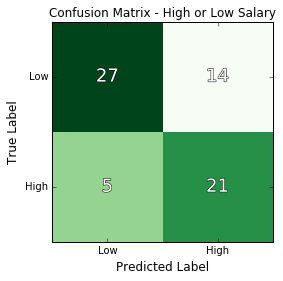

In [706]:
plot_confusion_matrix(lr_cm, title='Confusion Matrix - High or Low Salary', labels=['Low','High'], cmap=plt.cm.Greens)

In [657]:
y_final = indcsvmore1["High"]

In [661]:
indcsvmore1["intercept"] = 1

In [662]:
X_final = indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27]]

In [663]:
X_final = X_final.as_matrix(columns=None)
y_final = y_final.as_matrix(columns=None)

In [664]:
mdl = sm.MNLogit(y_final, X_final)
mdl_fit = mdl.fit()

         Current function value: 0.418918
         Iterations: 35


/Users/katty/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [665]:
mdl_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                  203
Model:                        MNLogit   Df Residuals:                      184
Method:                           MLE   Df Model:                           18
Date:                Wed, 06 Jul 2016   Pseudo R-squ.:                  0.3956
Time:                        18:49:19   Log-Likelihood:                -85.040
converged:                      False   LL-Null:                       -140.71
                                        LLR p-value:                 1.777e-15
==============================================================================
       y=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0650      0.912      0.071      0.943        -1.723     1.853
x2            20.8919   1.38e+04      0.002      0.999     -2.71e+04  2.71e+04
x3             1.1082      0.882      1.256      0.209        -0.621     2.837
x4             0.5917      1.316      0.449      0.653        -1.988     3.172
x5             0.6121      0.855      0.716      0.474        -1.064     2.288
x6             1.2523   6.34e+04   1.98e-05      1.000     -1.24e+05  1.24e+05
x7             0.3533      1.144      0.309      0.757        -1.889     2.596
x8             2.1889      1.019      2.148      0.032         0.192     4.186
x9             2.5783      1.331      1.938      0.053        -0.030     5.186
x10           -0.7977      0.550     -1.450      0.147        -1.876     0.281
x11            0.0423      0.690      0.061      0.951        -1.309     1.394
x12           -0.7204      0.967     -0.745      0.456        -2.616     1.175
x13            1.4792      0.608      2.432      0.015         0.287     2.671
x14           -1.0078      1.264     -0.797      0.425        -3.485     1.469
x15          -20.9494   2.53e+04     -0.001      0.999     -4.96e+04  4.96e+04
x16          -23.2287   1.69e+04     -0.001      0.999     -3.32e+04  3.32e+04
x17          -17.3385   1200.855     -0.014      0.988     -2370.971  2336.294
x18          -22.3573   3.39e+04     -0.001      0.999     -6.64e+04  6.63e+04
const         -0.4360      0.829     -0.526      0.599        -2.061     1.189
==============================================================================
"""

In [666]:
print(mdl_fit.aic)
print(mdl_fit.bic)

208.080525433
271.031439034


This addition performs better than the previous models

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [669]:
y_continuous = indcsvmore1["Salary"]

mod = sm.OLS(y_continuous, X_final)
res = mod.fit()

print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     7.181
Date:                Wed, 06 Jul 2016   Prob (F-statistic):           9.79e-14
Time:                        19:00:08   Log-Likelihood:                -2415.8
No. Observations:                 203   AIC:                             4870.
Df Residuals:                     184   BIC:                             4933.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1.368e+04   1.33e+04      1.029      0.3

In [673]:
indcsvmore1.iloc[:][[7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27]].head()

,Boston,Charlotte,Chicago,Denver,New York,Portland,Raleigh,San Francisco,Seattle,Analyst,Engineer,Manager,Senior,Specialist,Statistician,Education,Government,Healthcare,intercept
33,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
36,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
85,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Jobs that are in Charlotte, Seattle and San Francisco (x2, x8 and x9) likely have the highest salaries. 
Seniors likely have the highest salaries. 
People who are not employed in Education, Government or Healthcare are likely to have higher salaries.

In [676]:
indcsv.sort_values("Salary", ascending = False).head(10)

,Title,Location,Salary,Company,SalaryBinary
2084,Chief Data Scientist,"Boston, MA 02116 (South End area)",240000.0,Jobspring Partners,High
146,Quantitative Analyst for Global Quant Fund,"New York, NY",225000.0,Averity,High
556,Practice Leader for Management Consulting in P...,"Charlotte, NC",212500.0,BIG 6 Search International,High
277,Junior Quantitative Analyst / Developer for $5...,"New York, NY",200000.0,Averity,High
2114,Software Engineer - Machine Learning Team,"Boston, MA",200000.0,NJF Search,High
252,Quantitative Analyst (Fundamental Quant Equiti...,"New York, NY 10022 (Midtown area)",200000.0,Datacom Technology Group,High
391,Senior/ Lead Data Scientist for Digital Media ...,"New York, NY",200000.0,Averity,High
1937,Quantitative Researcher - Statistical Machine ...,"Berkeley, CA",200000.0,NJF Search,High
134,Data Scientist,"Armonk, NY",200000.0,Technical Source,High
1169,"Quantitative Researcher, Machine Learning & Ba...","Chicago, IL",200000.0,NJF Search,High


### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [23]:
## YOUR CODE HERE

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE